# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


## Model Definition

### Setup response model

In [4]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [5]:
loc += tb.rs("income", cluster="district", factor_scale=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


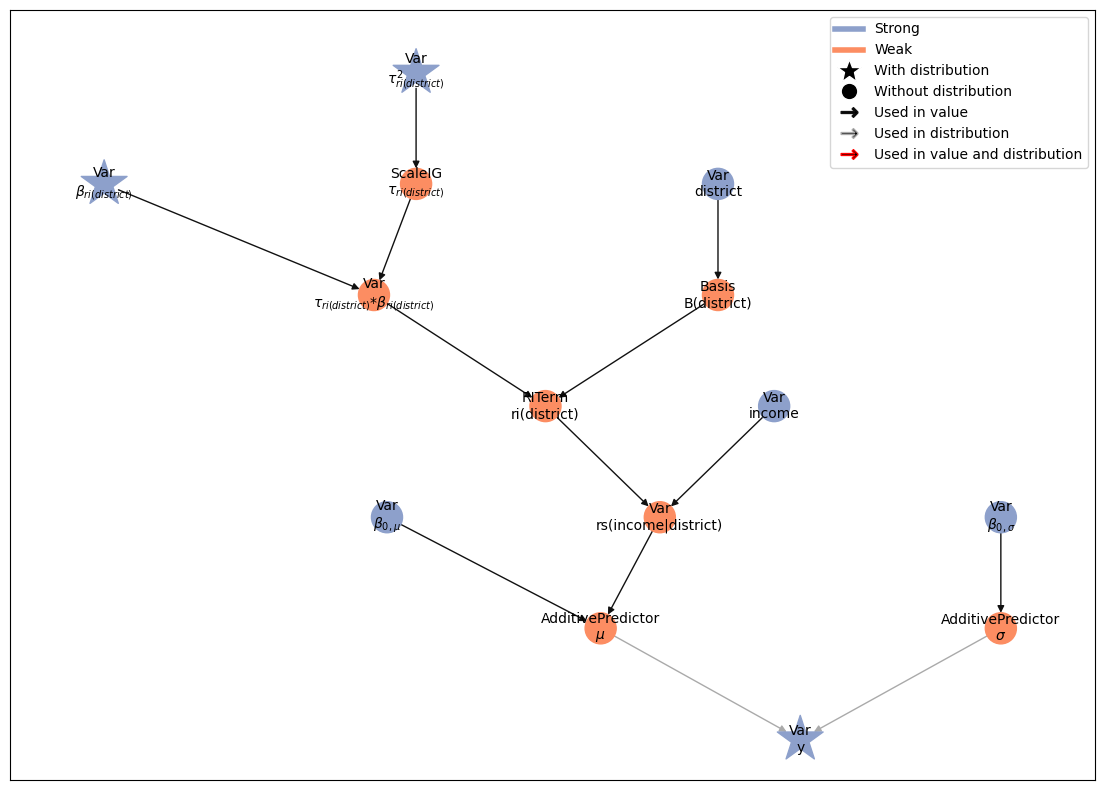

In [6]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [7]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ri(district)}$', '$\\tau_{ri(district)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:02<00:00,  1.03chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:00<00:00, 11.42chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [8]:
summary = gs.Summary(results)
summary

Parameter summary:

                                  kernel       mean        sd     q_0.05  \
parameter               index                                              
$\beta_{0,\mu}$         ()     kernel_01  35.205700  2.449469  31.168429   
$\beta_{0,\sigma}$      ()     kernel_00   2.814785  0.107803   2.643978   
$\beta_{ri(district)}$  (0,)   kernel_02  -0.149550  1.011764  -1.793733   
                        (1,)   kernel_02  -0.156694  0.999332  -1.818371   
                        (2,)   kernel_02  -0.022470  1.005256  -1.675336   
                        (3,)   kernel_02   0.020327  0.989178  -1.587049   
                        (4,)   kernel_02   0.062295  0.974226  -1.544892   
                        (5,)   kernel_02  -0.067607  0.996991  -1.695521   
                        (6,)   kernel_02  -0.140477  1.010062  -1.803054   
                        (7,)   kernel_02   0.015098  0.994286  -1.572399   
                        (8,)   kernel_02  -0.029623  0.979467  -1.659029   
                        (9,)   kernel_02  -0.007052  1.001350  -1.669084   
                        (10,)  kernel_02   0.105332  0.981781  -1.514487   
                        (11,)  kernel_02   0.096634  0.985696  -1.517471   
                        (12,)  kernel_02   0.021292  0.983049  -1.629216   
                        (13,)  kernel_02   0.085475  1.011775  -1.567616   
                        (14,)  kernel_02   0.065382  0.989038  -1.545948   
                        (15,)  kernel_02   0.083964  0.998953  -1.534829   
                        (16,)  kernel_02   0.020062  0.992169  -1.600778   
                        (17,)  kernel_02   0.061893  0.987636  -1.578367   
                        (18,)  kernel_02   0.101397  1.015818  -1.580298   
                        (19,)  kernel_02  -0.409298  0.993877  -2.028548   
                        (20,)  kernel_02   0.021687  0.991052  -1.607439   
                        (21,)  kernel_02  -0.021332  0.974231  -1.618732   
                        (22,)  kernel_02  -0.145468  0.993787  -1.783674   
                        (23,)  kernel_02   0.019553  1.003393  -1.599527   
                        (24,)  kernel_02   0.139218  1.002922  -1.517436   
                        (25,)  kernel_02   0.021509  1.008070  -1.650407   
                        (26,)  kernel_02   0.078028  0.985659  -1.542917   
                        (27,)  kernel_02   0.051379  1.002433  -1.634726   
                        (28,)  kernel_02   0.074784  1.002733  -1.603812   
                        (29,)  kernel_02   0.200842  1.001843  -1.429474   
                        (30,)  kernel_02  -0.129754  0.995484  -1.730766   
                        (31,)  kernel_02  -0.093704  1.000903  -1.720932   
                        (32,)  kernel_02   0.062308  0.987723  -1.552611   
                        (33,)  kernel_02  -0.086987  0.998064  -1.705815   
                        (34,)  kernel_02   0.035038  0.999820  -1.610464   
                        (35,)  kernel_02  -0.161511  0.981592  -1.812029   
                        (36,)  kernel_02   0.057044  0.989867  -1.550283   
                        (37,)  kernel_02   0.089711  0.993911  -1.567816   
                        (38,)  kernel_02  -0.101033  0.983928  -1.725200   
                        (39,)  kernel_02  -0.240801  0.984874  -1.855641   
                        (40,)  kernel_02  -0.152367  1.001512  -1.752209   
                        (41,)  kernel_02  -0.166027  0.977543  -1.761164   
                        (42,)  kernel_02   0.003221  1.001013  -1.657148   
                        (43,)  kernel_02  -0.032537  1.017155  -1.704087   
                        (44,)  kernel_02  -0.043390  0.991569  -1.659987   
                        (45,)  kernel_02  -0.149088  0.994964  -1.763726   
                        (46,)  kernel_02  -0.070280  0.991442  -1.680281   
                        (47,)  kernel_02  -0.040485  1.011548  -1.662248   
                        (48,

## Plots

In [9]:
samples = results.get_posterior_samples()

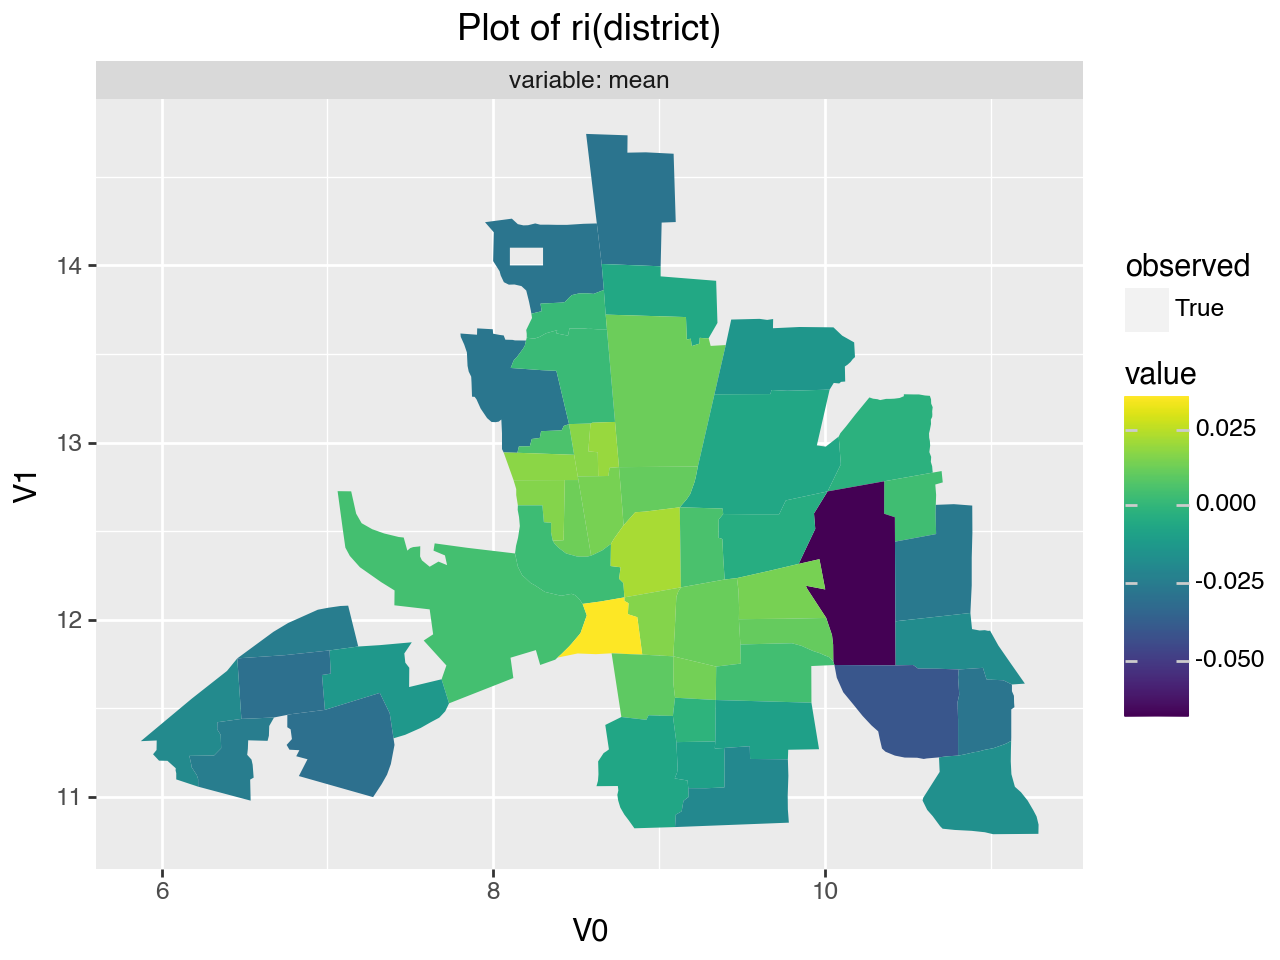

In [10]:
gam.plot_regions(model.vars["ri(district)"], samples, polys=polys)

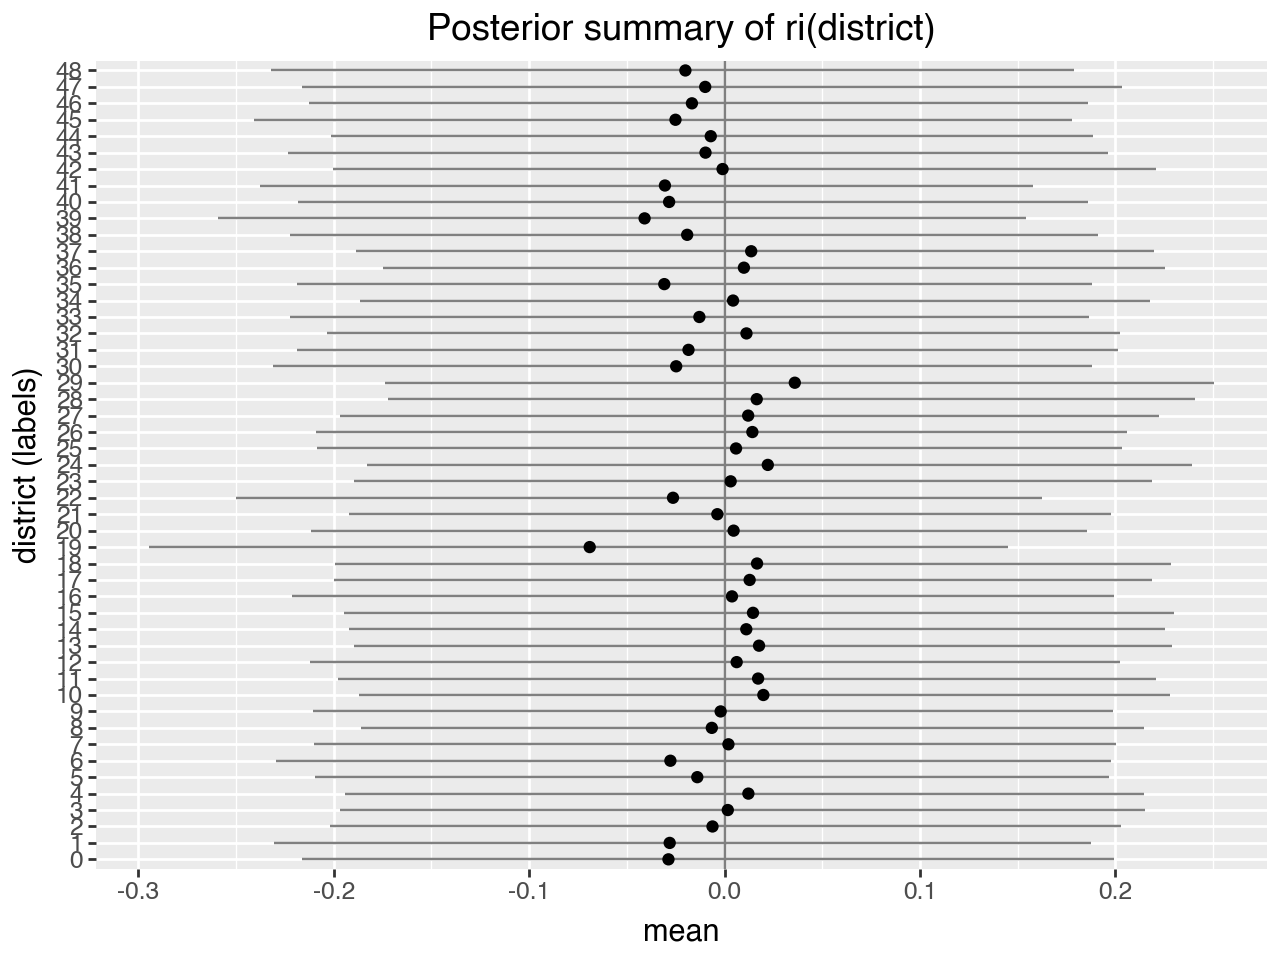

In [11]:
gam.plot_forest(model.vars["ri(district)"], samples)

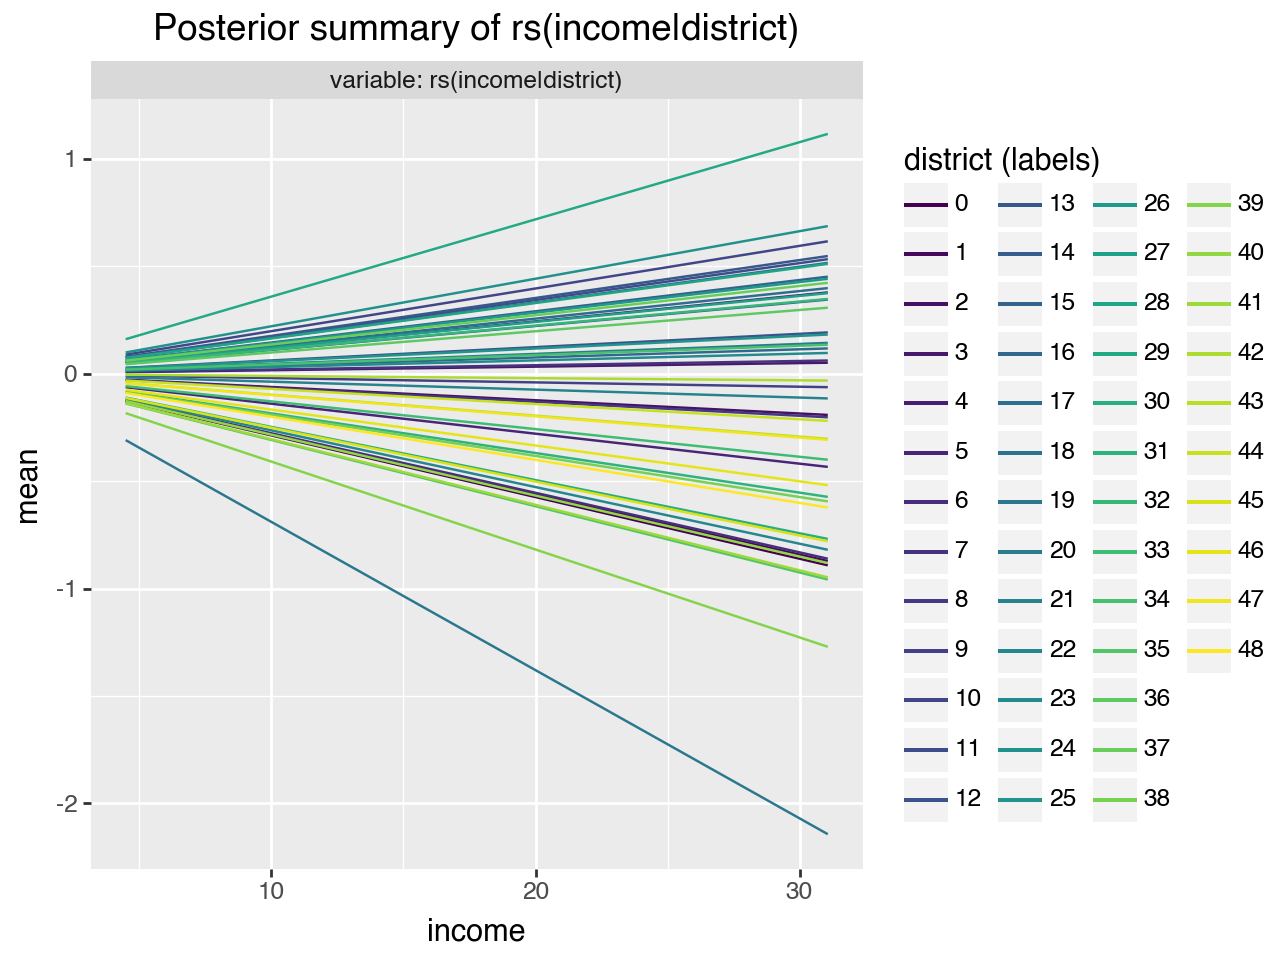

In [12]:
gam.plot_1d_smooth_clustered(
    clustered_term=model.vars["rs(income|district)"],
    samples=samples,
    ngrid=10,
)